In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [55]:
historical_data = pd.read_csv('Data/full_cleaned_data.csv')

In [56]:
import pandas as pd
import numpy as np

def price_weather_derivative(forecast_series: pd.Series,
                              historical_data: pd.DataFrame,
                              strike: float,
                              notional: float,
                              reference_temp: float = None) -> dict:
    """
    Prices HDD and CDD weather derivatives based on temperature forecasts.

    Parameters:
    - forecast_series: pd.Series with datetime index and forecasted temperatures.
    - historical_data: pd.DataFrame with columns ['date', 'mean'] for historical temperatures.
    - strike: float, strike value of the derivative.
    - notional: float, notional value used in the payout calculation.
    - reference_temp: Optional float to override historical-based reference temperature.

    Returns:
    - dict: Dictionary with 'HDD_price' and 'CDD_price'.
    """

    # Ensure datetime formats
    historical_data = historical_data.copy()
    historical_data['date'] = pd.to_datetime(historical_data['date'])
    forecast_series.index = pd.to_datetime(forecast_series.index)

    # Compute reference temperature if not provided
    if reference_temp is None:
        forecast_start_date = forecast_series.index[0]
        start_10_years_ago = forecast_start_date - pd.DateOffset(years=10)

        # Filter to last 10 years
        last_10_years = historical_data[historical_data['date'] >= start_10_years_ago]

        # Match month-day combinations
        forecast_month_day = set((d.month, d.day) for d in forecast_series.index)
        historical_matches = last_10_years[
            last_10_years['date'].apply(lambda d: (d.month, d.day) in forecast_month_day)
        ]

        # Calculate reference temperature
        reference_temp = historical_matches['mean'].mean()

    # Compute HDD and CDD for each day
    temps = forecast_series.values
    hdd = np.maximum(0, reference_temp - temps)
    cdd = np.maximum(0, temps - reference_temp)

    # Compute indices
    hdd_index = np.sum(hdd)
    cdd_index = np.sum(cdd)

    # Derivative prices
    hdd_price = notional * max(0, hdd_index - strike)
    cdd_price = notional * max(0, cdd_index - strike)

    return {
        "HDD_price": hdd_price,
        "CDD_price": cdd_price
    }

In [57]:
# open up csv file forecast
SARIMAforecast = pd.read_csv('Forecasts/SARIMA_Forecast.csv', index_col=0)

# Take only the first 31 rows
SARIMAforecast = SARIMAforecast.iloc[1:31]

In [58]:
import json

# Define the file path
file_path = '/Users/gianiranzetti/Github/Minerva---Weather-Derivatives/Forecasts/forecast_mc_results.json'

# Open and load the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# convert data to df
UOmodelforecast = pd.DataFrame(data)

UOmodelforecast.index = SARIMAforecast.index
UOmodelforecast

,mean_forecast,lower_ci_95,upper_ci_95
2024-07-01,26.085000,26.085000,26.085000
2024-07-02,25.981536,23.201491,28.866340
2024-07-03,25.976893,22.641661,29.619539
2024-07-04,25.892599,21.851353,29.952961
2024-07-05,25.867792,21.468188,30.552133
2024-07-06,25.912758,21.137848,30.772659
2024-07-07,25.886654,20.855541,30.943736
2024-07-08,25.914547,20.799385,31.224147
2024-07-09,25.875804,20.839169,31.222619
2024-07-10,25.814589,20.508772,30.930354


In [59]:
# Assuming price_weather_derivative is defined and available
forecasts = [SARIMAforecast, UOmodelforecast]
forecast_names = ['SARIMA', 'UOmodel']  # Manually specifying the model names

column_names = UOmodelforecast.columns

prices = []

for forecast, model_name in zip(forecasts, forecast_names):  # Iterate over forecasts and corresponding model names
    forecast.columns = column_names
    
    for column in column_names:
                
        # Assuming the price_weather_derivative function calculates the prices based on historical data and forecast
        result = price_weather_derivative(forecast[column], historical_data, strike=0, notional=1)
        
        # Get the HDD and CDD prices from the result
        HDDprice = result["HDD_price"]
        CDDprice = result["CDD_price"]
        # Append the resulting prices to the list
        prices.append({
            'Model': model_name,  # Use model name directly
            'Column': column,
            'HDDprice': HDDprice,
            'CDDprice': CDDprice
        })

# Optionally, convert the 'prices' list to a DataFrame if needed for easy inspection:
import pandas as pd
prices_df = pd.DataFrame(prices)

# Print or return the final DataFrame
print(prices_df)


     Model         Column    HDDprice    CDDprice
0   SARIMA  mean_forecast   55.722708   17.917717
1   SARIMA    lower_ci_95  509.178990    0.000000
2   SARIMA    upper_ci_95    0.000000  433.569009
3  UOmodel  mean_forecast    0.385579    2.081504
4  UOmodel    lower_ci_95  137.677653    0.243364
5  UOmodel    upper_ci_95    0.000000  144.140074


In [60]:
import pandas as pd

# Assuming price_weather_derivative is defined and available
forecasts = [SARIMAforecast, UOmodelforecast]
forecast_names = ['SARIMA', 'UOmodel']  # Manually specifying the model names

column_names = UOmodelforecast.columns

prices = []

for forecast, model_name in zip(forecasts, forecast_names):  # Iterate over forecasts and corresponding model names
    forecast.columns = column_names
    
    for column in column_names:
                
        # Assuming the price_weather_derivative function calculates the prices based on historical data and forecast
        result = price_weather_derivative(forecast[column], historical_data, strike=0, notional=1)
        
        # Get the HDD and CDD prices from the result
        HDDprice = result["HDD_price"]
        CDDprice = result["CDD_price"]
        
        # Append the resulting prices to the list
        prices.append({
            'Model': model_name,  # Use model name directly
            'Column': column,
            'HDDprice': HDDprice,
            'CDDprice': CDDprice
        })

# Convert the list to a DataFrame for easy inspection
prices_df = pd.DataFrame(prices)

# Reshape the DataFrame to have the required format: one row per model
reshaped_df = prices_df.pivot(index='Model', columns='Column', values=['HDDprice', 'CDDprice'])

# Flatten the MultiIndex columns for easier access
reshaped_df.columns = [f'{col[0]}_{col[1]}' for col in reshaped_df.columns]

# Reset the index so the model names are included as a column
reshaped_df.reset_index(inplace=True)

# Print the reshaped DataFrame
reshaped_df


,Model,HDDprice_lower_ci_95,HDDprice_mean_forecast,HDDprice_upper_ci_95,CDDprice_lower_ci_95,CDDprice_mean_forecast,CDDprice_upper_ci_95
0,SARIMA,509.178990,55.722708,0.0,0.000000,17.917717,433.569009
1,UOmodel,137.677653,0.385579,0.0,0.243364,2.081504,144.140074


In [61]:
historical_data

,date,mean,max,min
0,1933-01-01,13.67,18.89,2.78
1,1933-01-02,13.89,19.61,1.89
2,1933-01-03,10.83,16.28,0.78
3,1933-01-04,14.94,21.28,1.28
4,1933-01-05,18.11,23.50,6.89
...,...,...,...,...
33646,2025-03-27,13.56,18.89,11.50
33647,2025-03-28,13.00,14.22,12.00
33648,2025-03-29,13.22,19.72,6.61
33649,2025-03-30,12.61,18.89,6.61


In [62]:
SARIMAforecast_filtered

,mean_forecast,lower_ci_95,upper_ci_95
2024-07-01,26.659525,22.722853,30.596198
2024-07-02,25.302329,19.733981,30.870678
2024-07-03,25.636870,18.733655,32.540085
2024-07-04,26.934982,18.856177,35.013788
2024-07-05,27.603724,18.474276,36.733173
2024-07-06,29.811247,19.731375,39.891119
2024-07-07,29.062184,18.111422,40.012945
2024-07-08,28.972298,17.214237,40.730358
2024-07-09,28.377263,15.863685,40.890842
2024-07-10,27.229585,14.003528,40.455642


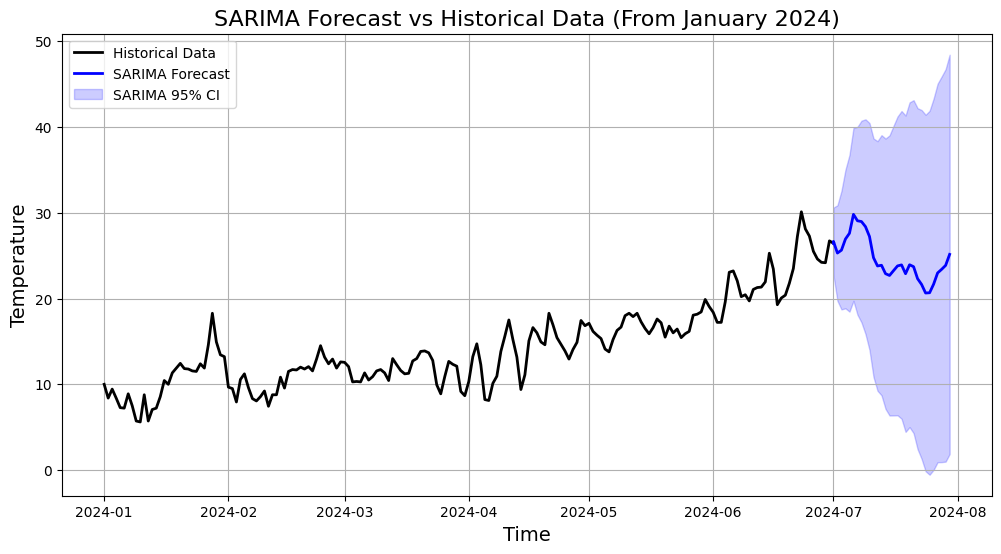

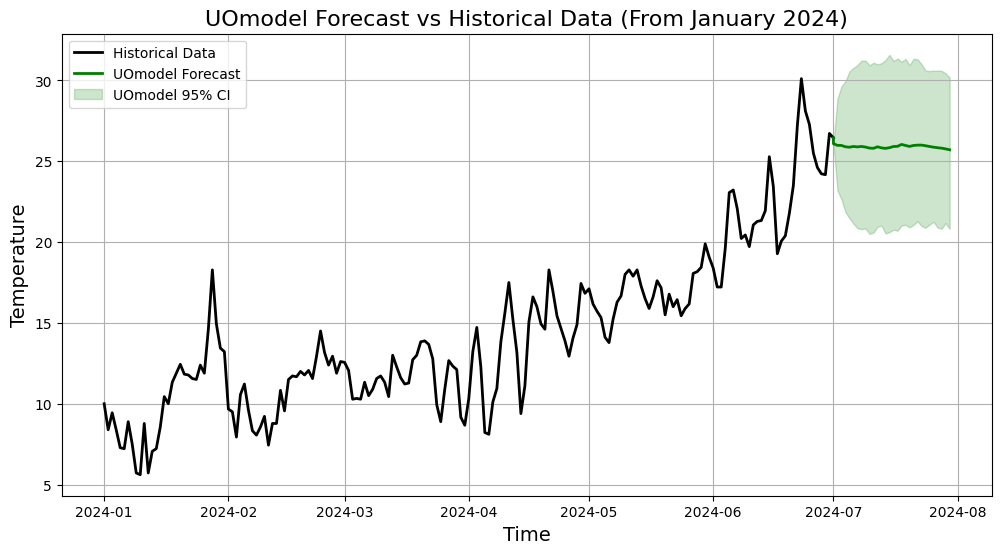

In [66]:
# Get the last value of the historical data
last_historical_date = historical_data['date'].iloc[-1]
last_historical_value = historical_data['mean'].iloc[-1]

# Add the last historical observation to the forecast data for both SARIMA and UOmodel

# For SARIMA forecast
SARIMAforecast_filtered_with_last = pd.DataFrame({
    'mean_forecast': [last_historical_value] + list(SARIMAforecast_filtered['mean_forecast']),
    'lower_ci_95': [last_historical_value] + list(SARIMAforecast_filtered['lower_ci_95']),
    'upper_ci_95': [last_historical_value] + list(SARIMAforecast_filtered['upper_ci_95'])
}, index=[last_historical_date] + list(SARIMAforecast_filtered.index))

# For UOmodel forecast
UOmodelforecast_filtered_with_last = pd.DataFrame({
    'mean_forecast': [last_historical_value] + list(UOmodelforecast_filtered['mean_forecast']),
    'lower_ci_95': [last_historical_value] + list(UOmodelforecast_filtered['lower_ci_95']),
    'upper_ci_95': [last_historical_value] + list(UOmodelforecast_filtered['upper_ci_95'])
}, index=[last_historical_date] + list(UOmodelforecast_filtered.index))

# Plotting for SARIMA model
plt.figure(figsize=(12, 6))
plt.plot(historical_data['date'], historical_data['mean'], label='Historical Data', color='black', linewidth=2)
plt.plot(SARIMAforecast_filtered_with_last.index, SARIMAforecast_filtered_with_last['mean_forecast'], label='SARIMA Forecast', color='blue', linestyle='-', linewidth=2)
plt.fill_between(SARIMAforecast_filtered_with_last.index, SARIMAforecast_filtered_with_last['lower_ci_95'], SARIMAforecast_filtered_with_last['upper_ci_95'], 
                 color='blue', alpha=0.2, label='SARIMA 95% CI')
plt.title('SARIMA Forecast vs Historical Data (From January 2024)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plotting for UOmodel
plt.figure(figsize=(12, 6))
plt.plot(historical_data['date'], historical_data['mean'], label='Historical Data', color='black', linewidth=2)
plt.plot(UOmodelforecast_filtered_with_last.index, UOmodelforecast_filtered_with_last['mean_forecast'], label='UOmodel Forecast', color='green', linestyle='-', linewidth=2)
plt.fill_between(UOmodelforecast_filtered_with_last.index, UOmodelforecast_filtered_with_last['lower_ci_95'], UOmodelforecast_filtered_with_last['upper_ci_95'], 
                 color='green', alpha=0.2, label='UOmodel 95% CI')
plt.title('UOmodel Forecast vs Historical Data (From January 2024)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
